In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.Citeseer import Citeseer
import dgl.function as fn

import torch
import numpy as np

torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
dataset = Citeseer() 

original_graph = dataset.load_graph(n_components = 1)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
original_graph = original_graph.to(device=device)
print(device)
dataset2 = Citeseer()
original_graph_2 = dataset2.load_graph(n_components = None)
original_graph_2 = original_graph_2.to(device=device)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
cuda:1
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
#original_graph = dataset.load_graph(n_components = 50)
from Projections.JLRandom import JLRandomProjection
original_graph = original_graph.to(device=device)
from Projections.CCA import CCA

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph_2, num_nearest_init_neighbors_per_type,initial_k_layer=2, device=device, pairs_per_level=10,norm_p=1, approx_neigh=True, 
                                add_feat=True, use_out_degree=True, use_zscore=False   , use_cos_sim=False   ,folder_name="test" , checkpoints=[0.1]           ) # , projection_cls= JLRandomProjection

coarsener.init()
coarsener.summarize()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


cites
step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:412: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:39.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9981965734896303
step: 2, ratio: 0.9963931469792606
step: 3, ratio: 0.9945897204688909
step: 4, ratio: 0.9927862939585211
step: 5, ratio: 0.9909828674481514
step: 6, ratio: 0.9891794409377818
step: 7, ratio: 0.9873760144274121
step: 8, ratio: 0.9855725879170424
step: 9, ratio: 0.9837691614066727
step: 10, ratio: 0.981965734896303
step: 11, ratio: 0.9801623083859333
step: 12, ratio: 0.9783588818755635
step: 13, ratio: 0.9765554553651938
step: 14, ratio: 0.9747520288548241
step: 15, ratio: 0.9729486023444545
step: 16, ratio: 0.9711451758340848
step: 17, ratio: 0.9693417493237151
step: 18, ratio: 0.9675383228133454
step: 19, ratio: 0.9657348963029756
step: 20, ratio: 0.9639314697926059
step: 21, ratio: 0.9621280432822362
step: 22, ratio: 0.9603246167718665
step: 23, ratio: 0.9585211902614968
step: 24, ratio: 0.9567177637511272
step: 25, ratio: 0.9549143372407575
step: 26, ratio: 0.9531109107303878
step: 27, ratio: 0.951307484220018
step: 28, ratio: 0.9495040577096483
ste

In [4]:
coarsend_graph = coarsener.summarized_graph
mapping = coarsener.get_mapping("paper")
#coarsener.make_mask(mapping, "paper")
labels = coarsener.get_labels( mapping, "paper")

coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() )    


ratio 0.09828674481514878


In [8]:
original_graph.nodes["paper"].data["feat"].shape

torch.Size([3327, 3703])

In [10]:
import importlib
import Models.SimpleHeteroGCN
importlib.reload(Models.SimpleHeteroGCN)
from Models.SimpleHeteroGCN import HeteroGCNCiteer, HeteroGCNCiteerDropout   , HeteroGCNCiteerCrazy 
from Models.ImprovedGCN import ImprovedGCN
from Experiments.model_helper import run_experiments
coarsend_graph = coarsend_graph.add_self_loop()
original_graph = original_graph.add_self_loop()
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph, HeteroGCNCiteerDropout, num_runs=1, 
                                                  target_node_type="paper", epochs=50,eval_interval=1, model_param={"hidden_dim": 256},
                    )
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


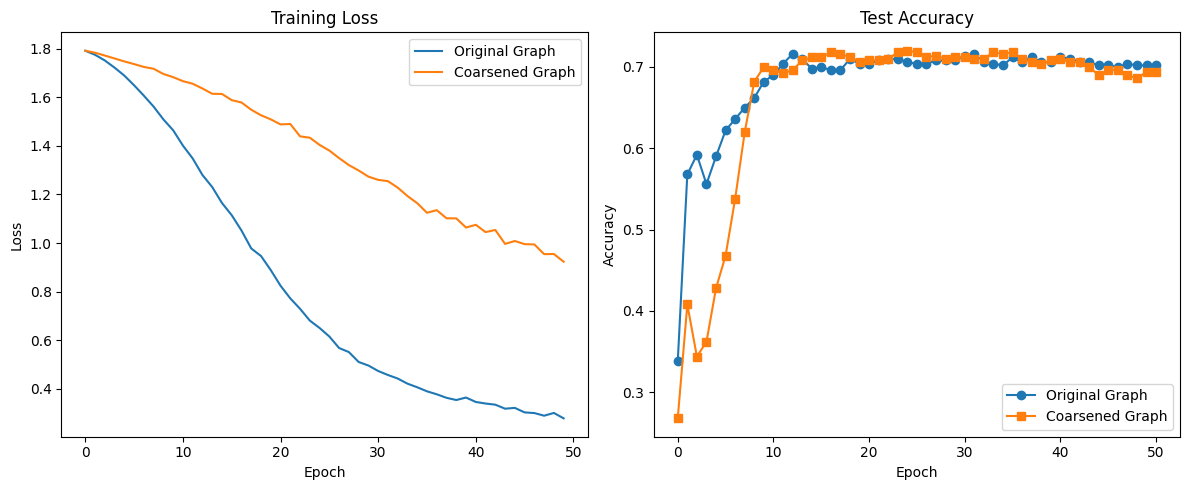

Final Performance Comparison:
Original Graph Accuracy: 0.7020
Coarsened Graph Accuracy: 0.6940

Original Graph Accuracy:
  Mean: 0.7020
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.6940
  Std:  0.0000


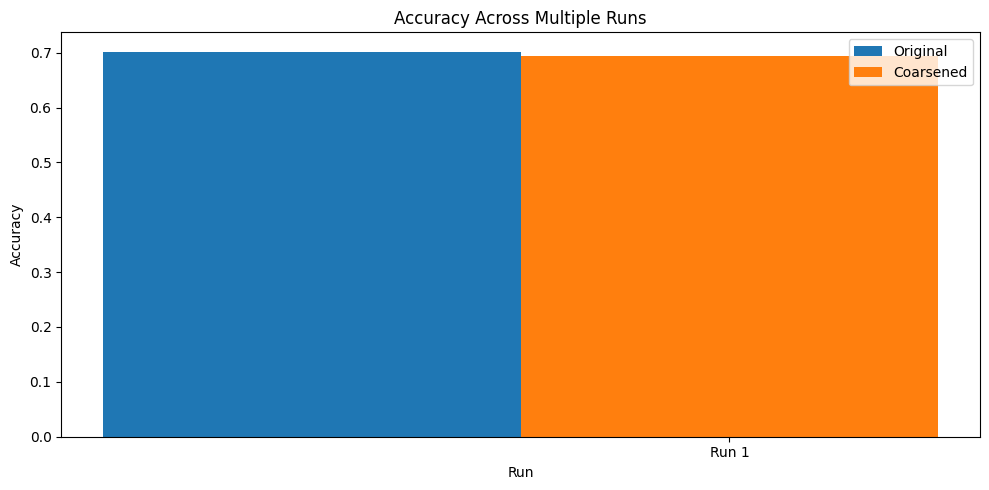

In [11]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(50))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

In [ ]:
"""
Relational GCN Network (RGCN).
Paper: https://arxiv.org/abs/1703.06103
"""

import dgl
import torch
import tqdm

from typing import Union, List


class GCNLayer(torch.nn.Module):
    def __init__(self, in_sizes: dict, out_sizes: dict, activation: bool = True,
                 use_layer_norm: bool = True, use_edge_weights: bool = True):
        """
        A single GCN layer.
        :param in_sizes: A dictionary of the dimensions of the input node representation for each node type.
        :param out_sizes: A dictionary of the dimensions of the output node representation for each node type.
        :param canonical_e_types: A list of edge / relation types in the graph.
        :param activation: A boolean representing whether to use an activation function on the output.
        :param use_layer_norm: A boolean representing whether to use layer normalization.
        :param use_edge_weights: A boolean representing whether the edge weights should be used during training.
        """
        super(GCNLayer, self).__init__()

        self.use_edge_weights = use_edge_weights

        activation_layer = torch.nn.Sequential(
            torch.nn.Identity()
        )

        if use_layer_norm:
            activation_layer.append(torch.nn.LayerNorm(out_sizes["_N"]))

        if activation:
            activation_layer.append(torch.nn.ReLU())

        if self.use_edge_weights:
            self.conv = dgl.nn.pytorch.GraphConv(in_sizes["_N"], out_sizes["_N"],
                                                 norm='none', activation=activation_layer)
        else:
            self.conv = dgl.nn.pytorch.GraphConv(in_sizes["_N"], out_sizes["_N"],
                                                 activation=activation_layer)

    def forward(self, graph: dgl.DGLGraph, h: torch.Tensor):
        """
        Perform a feed forward pass with the layer parameters.
        :param graph: A DGLGraph containing the graph structure.
        :param h: A dictionary mapping graph nodes to their associated initial representations.
        :return: The updated node feature dictionary mapping nodes to their output representation.
        """
        if self.use_edge_weights:
            return self.conv(graph, h, edge_weight=graph.edata["normalized_edge_weight"])
        else:
            return self.conv(graph, h)


class MLPInputLayer(torch.nn.Module):
    def __init__(self, h_feats: int, hidden_layer_size: int, use_layer_norm: bool):
        super().__init__()
        self.W1 = torch.nn.Linear(h_feats, hidden_layer_size)
        self.W2 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)

        self.output_layer = torch.nn.Identity()
        if use_layer_norm:
            self.output_layer = torch.nn.LayerNorm(hidden_layer_size)

    def forward(self, h: torch.tensor):
        return self.output_layer(self.W2(torch.nn.functional.relu(self.W1(h))).squeeze(1))


class GCN(torch.nn.Module):
    def __init__(self, graph: dgl.DGLGraph,
                 input_sizes: dict, out_sizes: Union[dict, int],
                 dropout: float, use_edge_weights: bool,
                 use_input_layer: bool, use_layer_norm: bool,
                 hidden_layer_sizes: Union[dict, int],
                 n_layers: int, softmax_output: bool = False,
                 log_softmax: bool = False):
        """
        A GCN network.
        :param graph: A DGLGraph containing the graph structure.
        :param input_sizes: A dictionary of the dimensions of the input node representation for each node type.
        :param out_sizes: A dictionary of the dimensions of the output node representation for each node type.
        :param dropout: A float setting the dropout rate during training.
        :param use_edge_weights: A boolean representing whether the edge weights should be used during training.
        :param use_layer_norm: A boolean representing whether to use layer normalization.
        :param use_input_layer: A boolean representing whether we should use an MLP input layer.
        :param hidden_layer_sizes: A dictionary of the dimensions of the hidden node representation for each node type.
        :param n_layers: The number of layers. Must be greater than 0.
        """
        super(GCN, self).__init__()

        assert n_layers >= 1

        self.softmax_output = softmax_output
        self.log_softmax = log_softmax

        self.dropout = dropout

        if isinstance(hidden_layer_sizes, int):
            self.hidden_layer_sizes_dict = {node_type: hidden_layer_sizes for node_type in graph.ntypes}
        else:
            self.hidden_layer_sizes_dict = hidden_layer_sizes

        if isinstance(out_sizes, int):
            self.out_sizes_dict = {node_type: out_sizes for node_type in graph.ntypes}
        else:
            self.out_sizes_dict = out_sizes

        self.use_input_layer = use_input_layer
        self.input_layer = None
        if self.use_input_layer:
            self.input_layer = MLPInputLayer(input_sizes["_N"], input_sizes["_N"], use_layer_norm)

        # GNN architecture
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()

        if self.n_layers > 1:
            # GNN Input layer
            self.layers.append(GCNLayer(input_sizes, self.hidden_layer_sizes_dict,
                                        activation=True, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))

            # GNN Hidden layers
            for i in range(1, self.n_layers - 1):
                self.layers.append(GCNLayer(self.hidden_layer_sizes_dict, self.hidden_layer_sizes_dict,
                                            activation=True, use_layer_norm=use_layer_norm,
                                            use_edge_weights=use_edge_weights))

            # GNN Output layer
            self.layers.append(GCNLayer(self.hidden_layer_sizes_dict, self.out_sizes_dict,
                                        activation=False, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))
        else:
            # GNN Input layer
            self.layers.append(GCNLayer(input_sizes, self.out_sizes_dict,
                                        activation=False, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))

    def forward(self, mfgs: List[dgl.DGLGraph], x: dict, out_key: str):
        """
        Perform a feedforward pass with the GNN on the provided graph to obtain a single node's output representation.
        :param mfgs: The message flow graphs for each layer.
        :param x: The input features of the nodes used in the first layer.
        :param out_key: The node the feedforward pass is obtaining a representation for.
        :return: The output representation of the specified node types.
        """
        x_transformed = x["_N"]
        if self.use_input_layer:
            x_transformed = torch.nn.functional.dropout(
                self.input_layer(x_transformed),
                p=self.dropout, training=self.training)

        # GNN Input layer
        h = self.layers[0](mfgs[0], x_transformed)

        if self.n_layers > 1:
            h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)

            # GNN Hidden layers
            for i in range(1, self.n_layers - 1):
                h = self.layers[i](mfgs[i], h)
                h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)

            # GNN Output layer
            h = self.layers[self.n_layers - 1](mfgs[self.n_layers - 1], h)
        if self.log_softmax:
            return torch.nn.functional.log_softmax(h, dim=1)
        elif self.softmax_output:
            return torch.nn.functional.softmax(h, dim=1)
        else:
            return h

    def inference(self, graph: dgl.DGLGraph, x: dict, indices: torch.tensor, device: torch.device, out_key: str):
        """
        Perform exact offline inference with this module.
        :param graph: A DGLGraph containing the graph structure.
        :param x: The input features of all the nodes.
        :param indices: The indices of the nodes to obtain an output representation for.
        :param device: The device to use for batched computations.
        :param out_key: The node type the feedforward pass is obtaining a representation for.
        :return: The output representation of the specified node types.
        """
        n_layer_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(num_layers=self.n_layers)
        dataloader = dgl.dataloading.DataLoader(
            graph, {out_key: indices}, n_layer_sampler,
            device="cpu", batch_size=indices.shape[0], shuffle=False,
            use_prefetch_thread=False, drop_last=False)

        # Compute representations layer by layer
        for i, layer in enumerate(self.layers):
            y = {node_type: torch.zeros(graph.number_of_nodes(node_type),
                                        self.hidden_layer_sizes_dict[node_type] if i != self.n_layers - 1
                                        else self.out_sizes_dict[node_type], device="cpu")
                 for node_type in graph.ntypes}

            # Within a layer, iterate over nodes in batches.
            for _, _, mfgs in tqdm.tqdm(dataloader, "Full Inference. Layer: {}".format(i), leave=False):
                step_size = 128 * 1024
                for start_idx in tqdm.tqdm(range(0, mfgs[i].number_of_dst_nodes(), step_size), "Internal inference batches", leave=False):
                    mfg_indices = (start_idx, min(start_idx + step_size, mfgs[i].number_of_dst_nodes()))
                    dst_node_indices = mfgs[i].dstnodes["_N"].data["_ID"][mfg_indices[0]: mfg_indices[1]]

                    one_layer_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(num_layers=1)
                    one_layer_dataloader = dgl.dataloading.DataLoader(
                        graph, {out_key: dst_node_indices}, one_layer_sampler,
                        device=device, batch_size=step_size, shuffle=False,
                        use_prefetch_thread=False, drop_last=False)

                    for _, _, blocks in one_layer_dataloader:
                        block = blocks[0]

                        # Copy the node representations that are needed for the layer to device.
                        h = x["_N"].to(device)[block.srcnodes["_N"].data["_ID"].to(device)]

                        if self.use_input_layer and (i == 0):
                            h = torch.nn.functional.dropout(self.input_layer(h), p=self.dropout, training=self.training)

                        h = torch.nn.functional.dropout(layer(block, h), p=self.dropout, training=self.training)

                        # Copy output back to CPU.
                        for node_type in block.ntypes:
                            y[node_type][block.dstnodes[node_type].data["_ID"]] = h.cpu()

            x = y

        if self.log_softmax:
            return torch.nn.functional.log_softmax(y[out_key][indices], dim=1)
        elif self.softmax_output:
            return torch.nn.functional.softmax(y[out_key][indices], dim=1)
        else:
            return y[out_key][indices]

def add_norm_edge_weights(g):
    # Compute degree
    degs = g.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    g.ndata['norm'] = norm

    # Assign edge weight as norm(u) * norm(v)
    g.apply_edges(lambda edges: {'normalized_edge_weight': edges.src['norm'] * edges.dst['norm']})
    return g


import dgl
from dgl.data import CiteseerGraphDataset

dataset = CiteseerGraphDataset()
graph = dataset[0]
graph = graph.to(device)
#graph = dgl.remove_self_loop(graph)
#graph = dgl.add_self_loop(graph)
graph = add_norm_edge_weights(graph)

features = graph.ndata['feat']
labels = graph.ndata['label']
in_feats = features.shape[1]
n_classes = dataset.num_classes

input_sizes = {"_N": in_feats}
hidden_sizes = {"_N": 256}  # you can change the hidden size
output_sizes = {"_N": n_classes}
x_dict = {"_N": features}
model = GCN(
    graph=graph,
    input_sizes=input_sizes,
    out_sizes=output_sizes,
    dropout=0.5,
    use_edge_weights=False,
    use_input_layer=False,
    use_layer_norm=False,
    hidden_layer_sizes=hidden_sizes,
    n_layers=2,  # you can try 1 or more
    softmax_output=False,
    log_softmax=True  # good for classification
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()  # because we're using log_softmax

features = graph.ndata['feat']
labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

x = {"_N": features}
out_key = "_N"

for epoch in range(1000):
    model.train()
    logits = model([graph] * model.n_layers, x, out_key)
    loss = loss_fn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (logits[val_mask].argmax(1) == labels[val_mask]).float().mean()
    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")



